# 1. Experiment 2: 
"find parameters for synthetic observation(s) reserved from the process-based model upon which the surrogate model was trained"
1. Build Surrogate of ParFlow streamflow, `lstm_A`
2. Construct amortized (full) P(`theta | q_surr_all`) via a Neural Density Estimator, or `NDE`
3. Sample posterior, P(`theta | q_surr_all = q_PF_obs`)
4. Interpretive Plots

##### --------
* Steps 1, 2 and embedded in the `lstm_sbi.py` 'run' script
* steps 3, 4 are shown below. 
* See `/home/qh8373/SBI_TAYLOR/sbi_taylor/psuedocode-sbi-experiments.md` for full details about the experiment

* NOTES:
    * Many Workflows tested and lent from:
        * `AGU_Synthesis.ipynb`
        * `SBI_Interp_Agg.ipynb`
        * `test_lstm_sbi.ipynb`

In [1]:
import os
import os.path
import sys
import shutil
from pprint import pprint
from datetime import datetime
from copy import copy
from copy import deepcopy
import pickle

from parflowio.pyParflowio import PFData

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import glob


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# -- Libararies  
import os
import sys
import pickle
import torch
from random import *

# for SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi import inference
from sbi.inference.base import infer
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.types import Array, OneOrMore, ScalarFloat

from matplotlib import pyplot as plt

import numpy as np
from numpy import cov
from numpy.linalg import det, norm # determinant, norm (used to calculate 'euclidean' distance)

import random
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from seaborn import pairplot
from seaborn import jointplot
import pandas as pd
from parflowio.pyParflowio import PFData
# import pygmmis <- This was the default but it doesn't work very well
from sklearn.mixture import GaussianMixture as GMM
import sys
import os
from datetime import datetime

# for machine learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset # for refactoring x and y
from torch.utils.data import DataLoader # for batch submission
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Independent, Uniform
from torch.distributions.log_normal import LogNormal

# for scaling
from sklearn.preprocessing import MinMaxScaler

# for stats
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from assessutils import compute_stats
import re
from scipy.stats import mode

# helpers
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/03_sbi_lstm/')
from sbi_build import simulate

# Path to the SandTank Repo
dev_path = '/home/SHARED/ML_TV/HydroGEN/modules/'
#Add Sand Tank path to the sys path
sys.path.append(dev_path)
from transform import float32_clamp_scaling

# user defined functions
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from genutils import PFread, plot_stuff, convertNumpy
from ensembleutils import assembleYears, assembleAllForcings, parseAllMetadata, returnDF_ens, returnAOC_ens, _ret_MinMax, _ret_AOCMinMax
from assessutils import compute_stats
from scalerutils import scaled_ens_Values, scaledForcingData, scaledAOCData
from posteriorsamputils import statTheta, genProbThetas, gen_Fit_Series_Wrapper
from summaryutils import summary, setStatSim
from sbiutils import retStatTyp, parseListDf, parseUniqueParams
from sbiutils import reshape_y, createYHatList, createYHat
from interputils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.tri as tri
import pickle
import sys
import torch

import scipy
from scipy.spatial import distance

/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## 3. Sample posterior, P(`theta | q_surr_all = q_PF_obs`)
* Default routine samples each posterior just once

## 4. Interpretive Plots


# -------------------------------------

### *Dimension 1* - Using the single surrogate model from `lstm_A`
### Loading SBI Posteriors

In [2]:
# Directories
sbi_run  = '0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate'
print(sbi_run)
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/{sbi_run}/'

try:
    os.mkdir(f'{save_dir}')
except:
    print('warning: file exists')
    pass

print(save_dir)

lstm_name = '02_05_lstm_A'
lstm_path = f'/home/qh8373/SBI_TAYLOR/data/04_lstm_out/{lstm_name}/'

# load lstm info
with open(lstm_path+'list_df_cond.pkl', 'rb') as fp:
    list_df_cond = pickle.load(fp)

0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate
/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate/


### a. Interpretive plots for each synthetic observations, parameters only

#### Selection Criteria and Load Posterior

In [3]:
# Selection Criteria
sub = 0 # Posterior Sub (Lsim=0 to 10)
idx = 1 #PF:LSTM, 0=82, 1=83, .... #Observation
lstm_idx = 0 #LSTM number in ensemble, nb: should be the same idx as that used in inference = 0
n_samples = 5000 
sbi_dir_sub = f'{sbi_dir}{sub}/'

add_noise=True
f_noise=1e-2

# load posterior
with open(sbi_dir_sub+'posterior.pkl', 'rb') as fp:
    posterior = pickle.load(fp)

#### General loading for posterior sampling

In [4]:
'''
ParFlow truth loads
lstm_df_cond should be loaded
to test ParFlow truths on models trained with LSTMs and previous tested with LSTM synthetic truths
'''
DataX_test, DataY_test, series_len, lstm_out_list = parseListDf(list_df_cond)
test_params, num_params, num_unique, DataX_test = parseUniqueParams(DataX_test, series_len)


'''
sample observation (y_hat) and 'correct' parameter (true_theta)
    y_hat_full is the full timeseries (important for embed and summary stat method)
'''
true_theta = test_params[idx]

#### Load y_hat_emulated

In [5]:
# emulated streamflow
y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))
y_hat = createYHat(y_hat_full, stat_method='full', stat_typ=None, embed_type=None)


/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


#### Sample Posterior (ParFlow)
* nb: to check for bias


the theta value is tensor([0.5995, 0.8495]) 

PARFLOW


<ipython-input-6-42710865eae3>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),


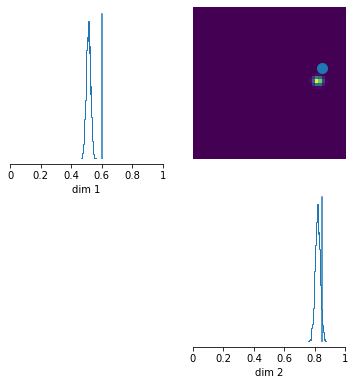

In [6]:
# PF
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method='full', stat_typ=None, embed_type=None)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)
y_hat_PF = unique_series_PF[idx]
y_hat_full_PF = unique_series_full_PF[idx]

'''
sample posterior and create log probability
'''
# PF
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples_PF = posterior.sample((n_samples,), x=y_hat_PF) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability_PF = posterior.log_prob(posterior_samples_PF, x=y_hat_PF).unsqueeze(1) # type - tensor object


'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('PARFLOW')
fig, ax = analysis.pairplot(posterior_samples_PF, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
# fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.png')
# fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.eps', format='eps')

plt.show()



### b. Interpretive plots for each synthetic observations, streamflow timeseries only

#### Bootstrap + Get Truth (ParFlow)

In [7]:
'''
bootstrap
'''
# PARFLOW
boots_params_PF, boots_logprob_PF, idxs_PF = randBootstrap(posterior_samples_PF, log_probability_PF)

'''
get 'truth'
'''
# PARFLOW
y_hat_plot_PF = y_hat_full_PF.T.detach().numpy()
y_len = len(y_hat_plot_PF)


#### Run Forward Simulations (ParFlow)

In [8]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list,
                          add_noise=True,f_noise=1e-02, lstm_idx=lstm_idx, y_len=y_len)



Caution, multiple emulators available


#### Plot time series (ParFlow)

Parflow, 1 simulator


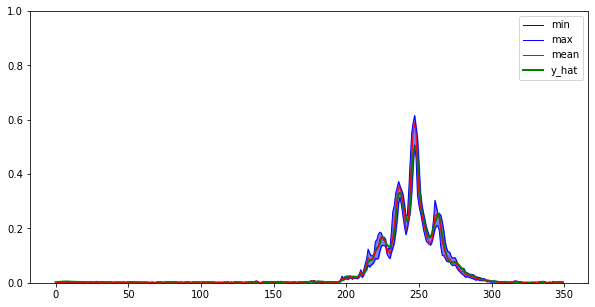

In [9]:
x = np.linspace(0,len(y_hat_plot_PF)-1, len(y_hat_plot_PF))

# PARFLOW
print('Parflow, 1 simulator')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims_PF.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims_PF.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_PF.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims_PF.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot_PF, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims_PF.T.min(axis=1), y_sims_PF.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
# fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.png')
# fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.eps', format='eps')
plt.show()

### *Dimension 3b* - Ensemble of weakly-trained surrogates -  Increase the diversity of our system representations to combat bias.
### Loading SBI Posteriors

In [10]:
# Directories
sbi_run  = '0819_01_mod2_02_09_lstm_C_0210_01_full_surrogate'
print(sbi_run)
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/{sbi_run}/'

try:
    os.mkdir(f'{save_dir}')
except:
    print('warning: file exists')
    pass

print(save_dir)

lstm_name = '02_09_lstm_C'
lstm_path = f'/home/qh8373/SBI_TAYLOR/data/04_lstm_out/{lstm_name}/'

# load lstm info
with open(lstm_path+'list_df_cond.pkl', 'rb') as fp:
    list_df_cond = pickle.load(fp)

0819_01_mod2_02_09_lstm_C_0210_01_full_surrogate
/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/0819_01_mod2_02_09_lstm_C_0210_01_full_surrogate/


### a. Interpretive plots for each synthetic observations, parameters only

#### Selection Criteria and Load Posterior

In [11]:
# Selection Criteria
sub = 0 # Posterior Sub (Lsim=0 to 10)
idx = 1 #PF:LSTM, 0=82, 1=83, .... #Observation
lstm_idx = 0 #LSTM number in ensemble, nb: should be the same idx as that used in inference = 0
n_samples = 5000 
sbi_dir_sub = f'{sbi_dir}{sub}/'

stat_method = 'full'
stat_typ = None
embed_type = None
out_dim = None

add_noise = False
f_noise = 1e-2
rand_lstm = True

# load posterior
with open(sbi_dir_sub+'posterior.pkl', 'rb') as fp:
    posterior = pickle.load(fp)

#### General loading for posterior sampling

In [12]:
'''
ParFlow truth loads
lstm_df_cond should be loaded
to test ParFlow truths on models trained with LSTMs and previous tested with LSTM synthetic truths
'''
DataX_test, DataY_test, series_len, lstm_out_list = parseListDf(list_df_cond)
test_params, num_params, num_unique, DataX_test = parseUniqueParams(DataX_test, series_len)


'''
sample observation (y_hat) and 'correct' parameter (true_theta)
    y_hat_full is the full timeseries (important for embed and summary stat method)
'''
true_theta = test_params[idx]

#### Load y_hat_emulated (ensemble)

In [13]:
# emulated streamflow
y_hat_full_ensemble = np.array([reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[ens_idx]))[0,:].clone().detach().numpy() for ens_idx in range(10)])


/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


#### Sample Posterior (ParFlow)
* nb: to check for bias


the theta value is tensor([0.5995, 0.8495]) 

PARFLOW


<ipython-input-14-42abb9dd69d5>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),


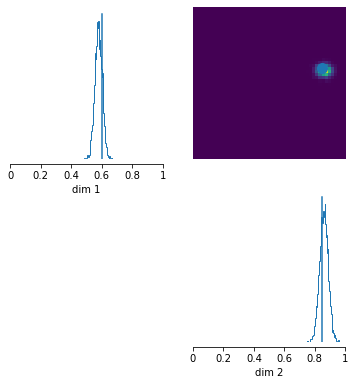

In [14]:
# PF
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method=stat_method, stat_typ=stat_typ, embed_type=embed_type)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)
y_hat_PF = unique_series_PF[idx]
y_hat_full_PF = unique_series_full_PF[idx]

'''
sample posterior and create log probability
'''
# PF
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples_PF = posterior.sample((n_samples,), x=y_hat_PF) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability_PF = posterior.log_prob(posterior_samples_PF, x=y_hat_PF).unsqueeze(1) # type - tensor object


'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('PARFLOW')
fig, ax = analysis.pairplot(posterior_samples_PF, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
# fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.png')
# fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.eps', format='eps')

plt.show()



### b. Interpretive plots for each synthetic observations, streamflow timeseries only

#### Bootstrap + Get Truth (ParFlow)

In [15]:
'''
bootstrap
'''
# PARFLOW
boots_params_PF, boots_logprob_PF, idxs_PF = randBootstrap(posterior_samples_PF, log_probability_PF)

'''
get 'truth'
'''
# PARFLOW
y_hat_plot_PF = y_hat_full_PF.T.detach().numpy()
y_len = len(y_hat_plot_PF)


#### Run Forward Simulations (ParFlow)

In [16]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list,
                          add_noise=add_noise, f_noise=f_noise,
                           rand_lstm=rand_lstm,
                           lstm_idx=lstm_idx, y_len=y_len)

print(len(lstm_out_list))
print(y_sims_PF[0,200])

Caution, multiple emulators available
10
0.02402058243751526


#### Plot time series (ParFlow)

Parflow


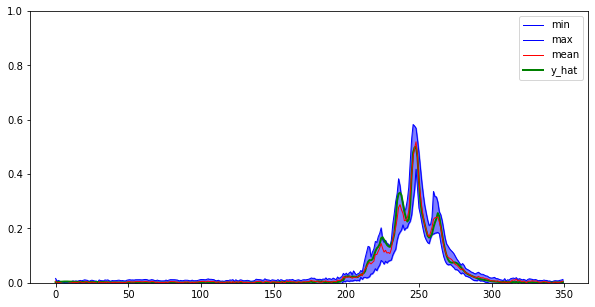

In [17]:
# PARFLOW
print('Parflow')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims_PF.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims_PF.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_PF.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims_PF.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot_PF, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims_PF.T.min(axis=1), y_sims_PF.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
# fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.png')
# fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.eps', format='eps')
plt.show()

## Check Bias

In [2]:
def _check_y(y):
    '''
    checks dimensions, converts to numpy
    '''
    if isinstance(y, torch.Tensor):
        y_o = y.clone().detach().numpy()
    else:
        y_o = y
        
    return y_o.flatten()
    
def _make_res_mets(y_hat, y_made):
    '''
    Makes metrics and arrays related to residuals
    '''
    # flatten
    y_hat = _check_y(y_hat)
    y_made = _check_y(y_made)
    
    # residuals
    res_arr = (y_made - y_hat)

    # metrics
    mean_res = res_arr.mean()
    std_res = res_arr.std()
    cor_res = np.corrcoef(res_arr)
    
    return res_arr, mean_res, std_res, cor_res

def _make_hist_mets(y_hat, y_made):
    '''
    
    '''
    # make stuff
    res_arr, mean_res, std_res, cor_res = _make_res_mets(y_hat, y_made)
    
    # Normalize the residual by atandard deviation
    res_std_res = res_arr / std_res
    res_median = np.quantile(res_std_res, q=0.5)

    # Standard Normal
    std_norm_arr = np.random.randn(350*10)
    std_norm_arr = std_norm_arr/std_norm_arr.std()
    
    return res_std_res, res_median, std_norm_arr

def _plt_res_time(y_hat, y_made, kernal_size=14, save=False, save_suite=None):
    '''
    plots residuals through time
    '''
    plt.subplots(figsize=(10,5))
    
    # make stuff
    res_arr, mean_res, std_res, cor_res = _make_res_mets(y_hat, y_made)
    
    # running average
    kernal_size = 14
    kernal_arr = np.ones(14)/14
    res_conv = np.convolve(res_arr, kernal_arr, mode='same')
    
    # plot
    plt.plot(res_arr, color='blue', label='residuals') # residuals
    plt.plot(res_conv, color='red', label='14-day Ave') # moving average
    plt.title('Model Residuals, ParFlow and LSTM')
    plt.ylim(-0.1, 0.1)
    plt.xlabel('Time, Days')
    plt.ylabel('Res = Y_LSTM - Y-ParFlow, [scaled streamflow units]')
    plt.legend(loc = 'lower left')

    textstr = '\n'.join((
        r'mean=%.2f' % mean_res,
        r'std=%.2f' % std_res,
        r'corrcoef=%.2f' % cor_res))


    # place a text box in upper left in axes coords
    plt.text(0.5, 0.075, textstr, fontsize=12,
            verticalalignment='top')
    
    if save:
        plt.savefig(f'{save_suite}_res_time.png')
        plt.savefig(f'{save_suite}_res_time.eps', format='eps')

    plt.show()
    
    return None


def _make_res_scatter(y_hat, y_made, save=False, save_suite=None):
    '''
    Making Scatters
    '''
    
    y_hat = _check_y(y_hat)
    y_made = _check_y(y_made)
    
    res_arr, mean_res, std_res, cor_res = _make_res_mets(y_hat, y_made)
    
    fig, ax = plt.subplots(1, 2, figsize=(14,6))

    # scatter plot with the relationship between residuals and flows, first the residuals, then the absolute of the residuals
    ax[0].scatter(y_made, res_arr, color='blue', s=5)
    ax[0].set_xlabel('Y_True_LSTTM, Scaled')
    ax[0].set_xscale('log')
    ax[0].set_xlim(0.0001, 1.0)
    ax[0].set_ylabel('Residuals, Scaled')
    ax[0].set_ylim(-0.1, 0.1)

    ax[1].scatter(y_hat, res_arr, color='blue', s=5)
    ax[1].set_xlabel('Y_True_ParFLow, Scaled')
    ax[1].set_xscale('log')
    ax[1].set_xlim(0.0001, 1.0)
    ax[1].set_ylabel('Residuals, Scaled')
    ax[1].set_ylim(-0.1, 0.1)

    plt.title("Residuals vs Flow, scaled")

    
    if save:
        fig.savefig(f'{save_suite}_res_scatter.png')
        fig.savefig(f'{save_suite}_res_scatter.eps', format='eps')
        
    plt.show()
    
    return None


def _make_res_hist(y_hat, y_made, save=False, save_suite=None):
    '''
    Making Histograms
    '''
    res_std_res, res_median, std_norm_arr = _make_hist_mets(y_hat, y_made)

    
    plt.subplots(figsize=(6,6))

    # plot as a histogram
    plt.hist(res_std_res,  bins=30, zorder=0, label='residuals', density=True)
    plt.hist(std_norm_arr, bins=30, zorder=1, alpha=0.5, label='unit normal', density=True)
    plt.plot(np.ones(2)*res_median, np.array([0, 1]), color='red', alpha=2, label='median, residuals')
    plt.xlim(-6, 6)
    plt.xlabel('Normalized Residual')
    plt.ylabel('Density')
    plt.ylim(0, 1)
    plt.legend()
    plt.title('Histogram of Residuals')
    
    # place a text box in upper left in axes coords
    plt.text(0.5, 0.075, r'median=%.2f' % res_median, fontsize=12,
            verticalalignment='top')

    if save:
        plt.savefig(f'{save_suite}_res_hist.png')
        plt.savefig(f'{save_suite}_res_hist.eps', format='eps')
        
    plt.show()
    
    return None


'''
ensemble functions
'''

def _make_res_ens(y_hat, y_made_ens):
    '''
    Makes metrics and arrays related to residuals
    '''
    res_ens_arr = np.empty(y_made_ens.shape)
    met_ens_arr = np.empty((len(y_made_ens), 3))
    
    for each in range(len(y_made_ens)):
        y_made_temp = y_made_ens[each]

        # do stuff
        res_ens_arr[each, :] = _make_res_mets(y_hat, y_made_temp)[0]
        met_ens_arr[each, :] = _make_res_mets(y_hat, y_made_temp)[1:]
        
        del y_made_temp
        
    return res_ens_arr, met_ens_arr

def _make_hist_mets_ens(y_hat, y_made_ens):
    '''
    
    '''
    # make stuff
    res_ens_arr, met_ens_arr = _make_res_ens(y_hat, y_made_ens) # mean_res, std_res, cor_res
    
    res_arr = res_ens_arr.flatten()
    std_res = res_ens_arr.std()
    
  
    # Normalize the residual by atandard deviation
    res_std_res = res_arr / std_res
    res_median = np.quantile(res_std_res, q=0.5)

    # Standard Normal
    std_norm_arr = np.random.randn(350*10)
    std_norm_arr = std_norm_arr/std_norm_arr.std()
    
    
    return res_std_res, res_median, std_norm_arr


def _plt_res_time_ens(y_hat, y_made_ens, kernal_size=14, save=False, save_suite=None):
    '''
    plots residuals through time
    '''
    plt.subplots(figsize=(10,5))
    
    # make stuff
    res_ens_arr, met_ens_arr = _make_res_ens(y_hat, y_made_ens)
    
    # metrics
    mean_res, std_res, cor_res = met_ens_arr.mean(axis=0)
    
    # running average
    kernal_size = 14
    kernal_arr = np.ones(14)/14
    
    # convolve
    res_conv_ens = np.empty(y_made_ens.shape)
    for each in range(len(y_made_ens)):
        res_conv_ens[each, :] = np.convolve(res_ens_arr[each], kernal_arr, mode='same')
    
    res_conv = res_conv_ens.mean(axis=0)
    
    # plot
    plt.plot(res_ens_arr.T, color='blue', label='residuals') # residuals
    plt.plot(res_conv, color='red', label='14-day Ave') # moving average
    plt.title('Model Residuals, ParFlow and LSTM')
    plt.ylim(-0.1, 0.1)
    plt.xlabel('Time, Days')
    plt.ylabel('Res = Y_LSTM - Y-ParFlow, [scaled streamflow units]')
    plt.legend(loc = 'lower left')

    textstr = '\n'.join((
        r'mean=%.2f' % mean_res,
        r'std=%.2f' % std_res,
        r'corrcoef=%.2f' % cor_res))


    # place a text box in upper left in axes coords
    plt.text(0.5, 0.075, textstr, fontsize=12,
            verticalalignment='top')
    
    if save:
        plt.savefig(f'{save_suite}_res_time.png')
        plt.savefig(f'{save_suite}_res_time.eps', format='eps')

    plt.show()
    
    return None


def _make_res_scatter_ens(y_hat, y_made_ens, save=False, save_suite=None):
    '''
    Making Scatters
    '''    
    y_hat = _check_y(y_hat)

    # make stuff
    res_ens_arr, met_ens_arr = _make_res_ens(y_hat, y_made_ens)
    
    fig, ax = plt.subplots(1, 2, figsize=(14,6))

    # scatter plot with the relationship between residuals and flows, first the residuals, then the absolute of the residuals
    for each in range(len(res_ens_arr)):
        ax[0].scatter(y_made_ens[each], res_ens_arr[each], color='blue', s=5)
    ax[0].set_xlabel('Y_True_LSTTM, Scaled')
    ax[0].set_xscale('log')
    ax[0].set_xlim(0.0001, 1.0)
    ax[0].set_ylabel('Residuals, Scaled')
    ax[0].set_ylim(-0.1, 0.1)

    for each in range(len(res_ens_arr)):
        ax[1].scatter(y_hat, res_ens_arr[each], color='blue', s=5)
    ax[1].set_xlabel('Y_True_ParFLow, Scaled')
    ax[1].set_xscale('log')
    ax[1].set_xlim(0.0001, 1.0)
    ax[1].set_ylabel('Residuals, Scaled')
    ax[1].set_ylim(-0.1, 0.1)

    plt.title("Residuals vs Flow, scaled")

    
    if save:
        fig.savefig(f'{save_suite}_res_scatter.png')
        fig.savefig(f'{save_suite}_res_scatter.eps', format='eps')
        
    plt.show()
    
    return None


def _make_res_hist_ens(y_hat, y_made_ens, save=False, save_suite=None):
    '''
    Making Histograms
    '''
    res_std_res, res_median, std_norm_arr = _make_hist_mets_ens(y_hat, y_made_ens)

    
    plt.subplots(figsize=(6,6))

    # plot as a histogram
    plt.hist(res_std_res,  bins=30, zorder=0, label='residuals', density=True)
    plt.hist(std_norm_arr, bins=30, zorder=1, alpha=0.5, label='unit normal', density=True)
    plt.plot(np.ones(2)*res_median, np.array([0, 1]), color='red', alpha=2, label='median, residuals')
    plt.xlim(-6, 6)
    plt.xlabel('Normalized Residual')
    plt.ylabel('Density')
    plt.ylim(0, 1)
    plt.legend()
    plt.title('Histogram of Residuals')
    
    
    # place a text box in upper left in axes coords
    plt.text(0.5, 0.075, r'median=%.2f' % res_median, fontsize=12,
            verticalalignment='top')
    
    if save:
        plt.savefig(f'{save_suite}_res_hist.png')
        plt.savefig(f'{save_suite}_res_hist.eps', format='eps')
        
    plt.show()
    
    return None

#### LSTM 1, ParFlow - LSTM mapping - 02_05_lstm_A


In [4]:

save_dir = '/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/081901_mod2_bias_comprison/'
sbi_name = '0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate_'
suite_name = f'lstm_idx_{lstm_idx}_sub_{sub}_runidx_{idx}'
save_suite = save_dir+sbi_name+suite_name

_plt_res_time(y_hat=y_hat_PF, y_made=y_hat_full, save=True, save_suite=save_suite)
_make_res_scatter(y_hat=y_hat_PF, y_made=y_hat_full, save=True, save_suite=save_suite)
_make_res_hist(y_hat=y_hat_PF, y_made=y_hat_full, save=True, save_suite=save_suite)

NameError: name 'y_hat_PF' is not defined

Looks like the residuals have a pattern through time and tend to be biased slightly high. These are the residuals of the 'true' ParFlow with respect to the 'true' inferred value from the first (simplest LSTM). We note that there is a pattern of the residuals through time that could be a cause of bias. 

This shows that there is some structure to the residuals with respect to flow. Namely they residuals are clearly related to the magnitude of the flows. But it isn't clear if there are any biases associated with this.

Normalized Density shows that we have a somewhat biased model with the residuals on average a bit high

#### LSTM 2, ParFlow - LSTM mapping - 02_10_lstm_A

In [57]:
# '''
# y_hat_full_ensemble
# '''

# fig, ax = plt.subplots(figsize=(10, 5))
# sub_sub = "{:02d}".format(idx)

# # ax.plot(y_sims_PF.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
# ax.plot(y_hat_full_ensemble.T, color='blue', linewidth=1, zorder=0, label='simulated, not inferred')
# ax.plot(y_hat_plot_PF, color='green', linewidth=2, label='y_hat', zorder=1)

# ax.set_ylim(0,1)
# ax.legend()
# # fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.png')
# # fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.eps', format='eps')
# plt.show()
# plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


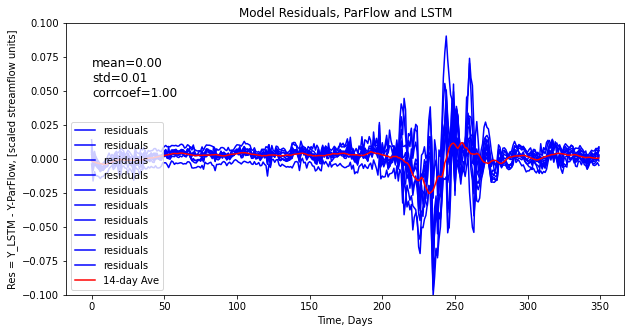

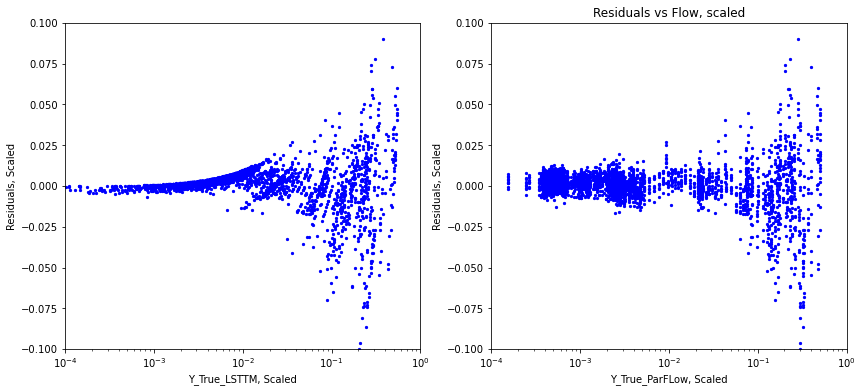

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

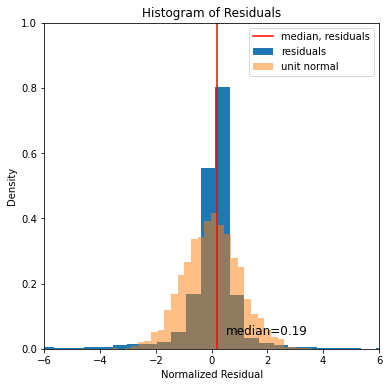

In [61]:
save_dir = '/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/081901_mod2_bias_comprison/'
sbi_name = '0819_01_mod2_02_09_lstm_C_0210_01_full_surrogate_'
suite_name = f'lstm_idx_all_sub_{sub}_runidx_{idx}'
save_suite = save_dir+sbi_name+suite_name

_plt_res_time_ens(y_hat=y_hat_PF, y_made_ens=y_hat_full_ensemble, save=True, save_suite=save_suite)
_make_res_scatter_ens(y_hat=y_hat_PF, y_made_ens=y_hat_full_ensemble, save=True, save_suite=save_suite)
_make_res_hist_ens(y_hat=y_hat_PF, y_made_ens=y_hat_full_ensemble, save=True, save_suite=save_suite)